# fvGP comprehensive test

## (0) Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from fvgp.gp import GP
%load_ext autoreload
%autoreload 2

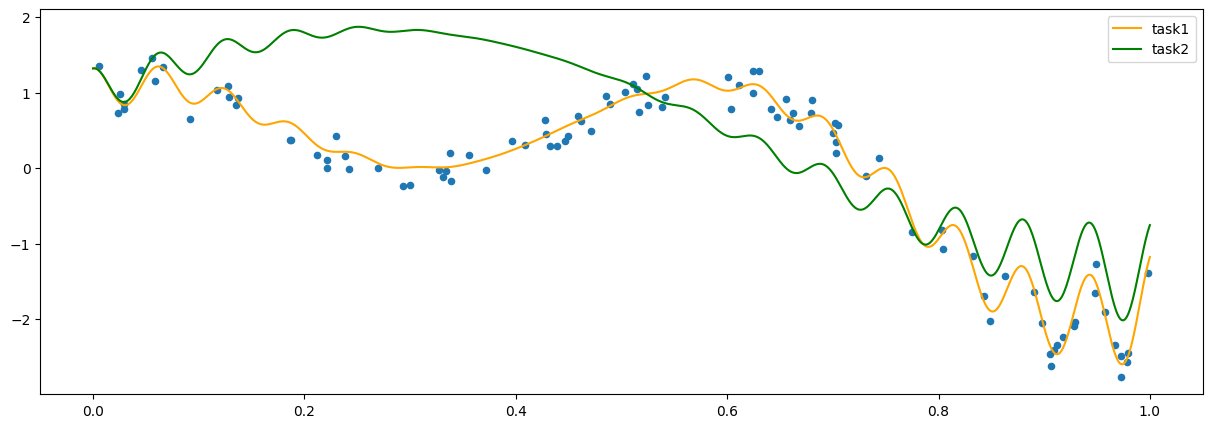

In [20]:
x = np.linspace(0,1,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

def f2(x):
    return np.sin(5. * x) + np.cos(2. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)

x_data = np.random.rand(100)
y_data = f1(x_data) + (np.random.rand(len(x_data))-0.5) * 0.5
plt.figure(figsize = (15,5))
plt.plot(x,f1(x), color = 'orange', label = 'task1')
plt.plot(x,f2(x), color = 'green',  label = 'task2')
plt.legend()
plt.scatter(x_data,y_data, s = 20)

In [30]:
#stationary
def skernel(x1,x2,hps,obj):
    d = obj._get_distance_matrix(x1,x2)
    return hps[0] * obj.matern_kernel_diff1(d,hps[1])

def noise(x, hps,obj):
    #print("noise evaluated")
    return np.diag(np.zeros((len(x))) + hps[2])


def meanf(x, hps, obj):
    #print(np.sin(hps[3] * x))
    return np.sin(hps[3] * x)[:,0]
#plt.figure(figsize = (15,5))
#plt.plot(x,meanf(x, np.array([1.,1.,5.0]), None), color = 'orange', label = 'task1')

Data Plot:


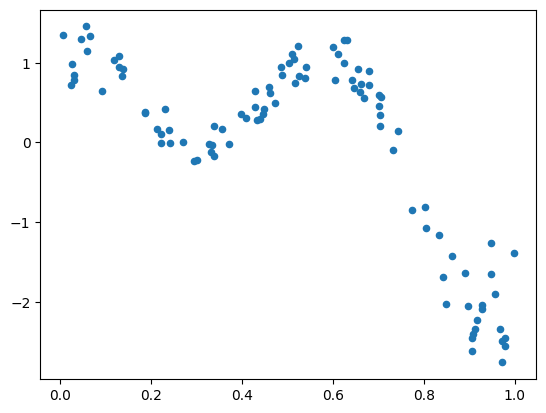

Global Training
hps:  [0.95477888 0.26051272 0.06486238 4.4074978 ]
Local Training
[0.95483918 0.26043405 0.06485934 4.40755198]
MCMC Training
Invalid or missing proposal covariance matrix.  Using identity.

[0.5828259  0.04801638 0.02615739 4.59753107]


In [31]:
my_gp1 = GP(1, x_data,y_data,np.ones((4)),
            noise_variances=None, 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            gp_noise_function=noise,
            normalize_y=False,
            sparse_mode=False,
            store_inv=True, 
            ram_economy=False, 
            args=None,
            )


print("Data Plot:")
plt.scatter(my_gp1.x_data,my_gp1.y_data, s = 20)
plt.show()
x_pred = np.linspace(0,1,1000)


hps_bounds = np.array([[0.001,10.],[0.001,10.],[0.001,10.],[0.001,10.]])

my_gp1.update_gp_data(x_data, y_data)
print("Global Training")
my_gp1.train(hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hps_bounds, method='mcmc', max_iter=1000)
print(my_gp1.get_hyperparameters())
#my_gp1.train(np.array([[0.001,10.],[0.001,10.]]), method='hgdl')


In [32]:
my_gp1.test_log_likelihood_gradient(my_gp1.hyperparameters)

Gradient correct
finite diff appr:  [ -0.92789843 -28.0713756  -89.46063694   0.30413965]
analytical      :  [ -0.92787586 -28.06010101 -89.44595469   0.30414188]


(array([ -0.92789843, -28.0713756 , -89.46063694,   0.30413965]),
 array([ -0.92787586, -28.06010101, -89.44595469,   0.30414188]))

In [ ]:
my_gp1.train(np.array([[0.001,10.],[0.001,10.]]), method='hgdl')

In [ ]:
opt_obj = my_gp1.train_async(np.array([[0.001,10.],[0.001,10.]]))

In [ ]:
my_gp1.update_hyperparameters(opt_obj)
for entry in opt_obj.optima.list:
    print(entry)
    print("")

#my_gp1.entropy(my_gp1.prior_covariance)

In [ ]:
#let's make a prediction
mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1))["v(x)"]

plt.figure(figsize = (16,10))
plt.plot(x,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x,f1(x), label = "latent function", linewidth = 4)
plt.fill_between(x, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
#plt.plot(x, (f(x)-mean1)**2)
plt.scatter(x_data,y_data, color = 'black')
#plt.legend(fontsize = 20)
plt.xticks([])
plt.yticks([])
print("error: ", np.sum(f1(x)-mean1)**2 / len(mean1))

In [ ]:
my_gp1.stop_training(opt_obj)
my_gp1.kill_training(opt_obj)

# Performance Tests

In [ ]:
my_gp1.entropy(my_gp1.K)